In [41]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData
from TransferEntropy.transfer_entropy import get_transfer_entropy
from constants import ATR_ABNORMALITY_COLUMN
from tqdm import tqdm
# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (70,30)

coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT"]
feature = "close"
kline_size = "1h"
main_coin_symbol = "BTCUSDT"
transfer_entropy_lookback = 2
suptitle_fontsize = 40
font_scale = 3
candle_size = "1d"
num_samples = 1440 # 60*24

In [2]:
data_manager = DataManager()
        # self.transfer_entropy = TransferEntropy(lookback=transfer_entropy_lookback, window_size=num_samples)

main_1d_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1d").df
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1m") for coin_symbol in coin_symbol_list]
# main_1h_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1h").df
main_abnormal_timestamp_list = main_1d_df[main_1d_df[ATR_ABNORMALITY_COLUMN] == 1].index

In [66]:
def add_HLOC(input_df):
    input_df["HLOC"] = input_df[["high", "low", "open", "close"]].mean(axis=1)

def join_dataframes(coin_data_list):
    df = pd.DataFrame(index=coin_data_list[0].df.index)

    for coin_data in coin_data_list:
        add_HLOC(coin_data.df)
        df = df.join(coin_data.df[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")
    
    df.rename(columns={feature:f"{feature}_{coin_data_list[0].coin_symbol}"}, inplace=True)    
    df.dropna(how="any", inplace=True)
    df.drop(columns=["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

In [68]:
feature = "HLOC"
raw_df = join_dataframes(coin_data_list=coin_data_list)

In [69]:
raw_df

,HLOC_BTCUSDT,HLOC_ETHUSDT,HLOC_ADAUSDT,HLOC_LTCUSDT
timestamp,,,,
2018-04-17 04:02:00,8032.2675,507.4825,0.262755,130.3775
2018-04-17 04:03:00,8029.5825,507.7750,0.265520,130.3475
2018-04-17 04:04:00,8031.9825,507.5625,0.264090,130.2375
2018-04-17 04:05:00,8030.2575,507.5750,0.266665,130.2000
2018-04-17 04:06:00,8030.3975,507.4225,0.268657,130.1900
...,...,...,...,...
2021-06-30 10:39:00,34821.2175,2136.3725,1.337850,140.7850
2021-06-30 10:40:00,34806.3500,2135.0400,1.337325,140.6150
2021-06-30 10:41:00,34757.6175,2132.1900,1.336250,140.3800


In [62]:
df = raw_df["2021-01-01":].resample("5min").median()

In [63]:
df

,close_BTCUSDT,close_ETHUSDT,close_ADAUSDT,close_LTCUSDT
timestamp,,,,
2021-01-01 00:00:00,28982.69,737.430,0.18113,124.59
2021-01-01 00:05:00,28934.84,735.000,0.17978,124.35
2021-01-01 00:10:00,28824.35,732.150,0.17888,123.76
2021-01-01 00:15:00,28810.00,731.610,0.17964,123.48
2021-01-01 00:20:00,28796.29,730.660,0.17923,123.29
...,...,...,...,...
2021-06-30 10:20:00,34729.98,2127.100,1.33600,140.51
2021-06-30 10:25:00,34803.06,2130.640,1.33980,140.65
2021-06-30 10:30:00,34776.45,2131.380,1.33730,140.69


In [64]:
df.describe()

,close_BTCUSDT,close_ETHUSDT,close_ADAUSDT,close_LTCUSDT
count,51850.000000,51850.000000,51850.000000,51850.000000
mean,45841.015095,2062.488879,1.120034,198.900507
std,10020.949339,703.907306,0.478692,57.696418
min,28767.580000,717.640000,0.169330,105.850000
25%,36183.572500,1605.630000,0.890013,157.650000
50%,47137.225000,1915.255000,1.206620,184.150000
75%,55843.362500,2453.457500,1.423297,225.200000
max,64615.460000,4360.040000,2.457400,411.600000


In [36]:
df = data_manager.add_noise_to_df(df, mu = 0, sigma = 10)
df.dropna(how="any", inplace=True)

In [37]:
df[df.duplicated()]

,close,close_ETHUSDT,close_ADAUSDT,close_LTCUSDT
timestamp,,,,


In [58]:
num_cols = len(df.columns)
n = len(df)
L = 3
result = np.ones(shape=(num_cols, num_cols))
for i, coli in tqdm(enumerate(df.columns)):
    for j, colj in enumerate(df.columns): 
        list_i, list_j = [], []
        arr_i = df[coli].to_numpy()
        arr_j = df[colj].to_numpy()

        # create windows.
        for l in range(L+1):
            list_i.append(arr_i[l:n-L+l])
            list_j.append(arr_j[l:n-L+l])
        
        entropy_value = get_transfer_entropy(np.array(list_i), np.array(list_j))
        result[i, j] = entropy_value

4it [03:37, 54.27s/it]


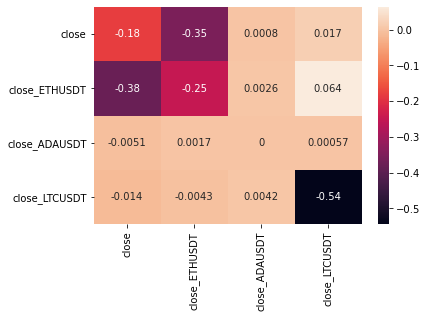

In [57]:
result = pd.DataFrame(data=result, columns=df.columns, index=df.columns)
sn.heatmap(result, annot=True);

In [50]:
listt = [1,2,3,4,5,6]
L = 3
n = len(listt)
for l in range(L+1):
    print(listt[l:n-L+l])

[1, 2, 3]
[2, 3, 4]
[3, 4, 5]
[4, 5, 6]
